# Algorytmy Macierzowe zadanie 3: Hierarchiczna kompresja macierzy
## Autorzy:

*   Kapcer Garus
*   Jakub Frączek







# Pseudokod
## Funkcja CompressMatrix
```plaintext
FUNKCJA CompressMatrix(A, U, D, V, r, sMin, tMin)
    JEŚLI A jest bliska zerowej macierzy
        ZWRÓĆ nowy węzeł z rank = 0, rozmiarem = długość boku A, sMin, tMin
    KONIEC JEŚLI

    ZWRÓĆ nowy węzeł z:
        rank = r,
        side = długość boku A,
        sMin, tMin,
        U = pierwsze r kolumn U,
        D = pierwsze r elementów D,
        V = pierwsze r wierszy V
KONIEC FUNKCJI
```
## Funkcja CreateTree
```plaintext
FUNKCJA CreateTree(A, r, eps, sMin = 0, tMin = 0)
    n = długość boku macierzy A
    (U, D, V) = zrób zrandomizowaną SVD macierzy A z r+1 wartościami osobliwymi

    JEŚLI liczba wartości osobliwych D jest <= r LUB D[r] < eps
        v = wywołaj CompressMatrix(A, U, D, V, długość D, sMin, tMin)
    W PRZECIWNYM RAZIE
        v = nowy węzeł z rank = None, side = n, sMin, tMin
        PODZIEL macierz A na 4 równe bloki:
            v.next dodaj wynik rekursywnego wywołania CreateTree dla:
                - lewego górnego bloku, z odpowiednimi sMin i tMin
                - lewego dolnego bloku, z przesuniętym sMin
                - prawego górnego bloku, z przesuniętym tMin
                - prawego dolnego bloku, z przesuniętymi sMin i tMin
    KONIEC JEŚLI

    ZWRÓĆ v
KONIEC FUNKCJI
```

In [1]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from scipy.linalg import svd
import gc

from sklearn.utils.extmath import randomized_svd


class Node:
    def __init__(self, rank=None, side=None, sMin=None, tMin=None, U=None, V=None, D=None):
        self.next: list[Node] = []

        self.sMin: int = sMin
        self.tMin: int = tMin
        self.side: int = side

        self.rank: int = rank
        self.U: np.ndarray[float] = U
        self.D: np.ndarray[float] = D
        self.V: np.ndarray[float] = V


def CompressMatrix(
    A: np.ndarray[float],
    U: np.ndarray[float],
    D: np.ndarray[float],
    V: np.ndarray[float],
    r: int,
    sMin: int,
    tMin: int,
):
    if np.allclose(A, np.zeros(A.shape)):
        return Node(rank=0, side=A.shape[0], sMin=sMin, tMin=tMin)

    return Node(
        rank=r,
        side=A.shape[0],
        sMin=sMin,
        tMin=tMin,
        U=U[:, :r],
        D=D[:r],
        V=V[:r, :],
    )


def CreateTree(A: np.ndarray[float], r: int, eps: float, sMin: int = 0, tMin: int = 0):
    n = A.shape[0]
    U, D, V = randomized_svd(A, r + 1)
    if len(D) <= r or D[r] < eps:
        v = CompressMatrix(A, U, D, V, len(D), sMin, tMin)
    else:
        v = Node(rank=None, side=n, sMin=sMin, tMin=tMin)
        v.next.append(CreateTree(A[: n // 2, : n // 2], r, eps, sMin, tMin))
        v.next.append(CreateTree(A[n // 2 :, : n // 2], r, eps, sMin + n // 2, tMin))
        v.next.append(CreateTree(A[: n // 2, n // 2 :], r, eps, sMin, tMin + n // 2))
        v.next.append(CreateTree(A[n // 2 :, n // 2 :], r, eps, sMin + n // 2, tMin + n // 2))
    return v


def DrawTree(root: Node):
    n = root.side
    fig, ax = plt.subplots()
    plt.axis("off")
    ax.set_aspect("equal", "box")
    ax.set_xlim(0, n)
    ax.set_ylim(n, 0)


    def DrawTreeRecursive(root: Node):
        nonlocal ax

        if root.rank is None:  # Not a leaf -> draw grid lines
            x, y, d = root.sMin, root.tMin, root.side // 2

            ax.plot((y + d, y + d), (x, x + 2 * d), color="k", lw=0.6)
            ax.plot((y, y + 2 * d), (x + d, x + d), color="k", lw=0.6)


        elif root.rank > 0:  # Leaf with SVD decomposition -> fill block
            x, y, d = (root.sMin, root.tMin + root.side, root.side)
            lw = root.side / (6 * root.rank)

            for i in range(root.rank):

                ax.fill([y, y, y - (i + 1) * lw, y - (i + 1) * lw], [x, x + d, x + d, x], color="k")
                ax.fill([y, y, y - d, y - d], [x, x + (i + 1) * lw, x + (i + 1) * lw, x], color="k")

        elif root.rank == 0:  # Leaf with all 0s -> pass
            pass

        for node in root.next:
            DrawTreeRecursive(node)



    DrawTreeRecursive(root)

    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)

    # Wczytanie obrazu z bufora do numpy
    img = Image.open(buf)
    img_array = np.array(img)

    # Zamknięcie figury po zapisaniu
    plt.close(fig)
    del fig, ax, img, buf
    gc.collect()

    return img_array




def Decompress(root: Node):
    n = root.side
    A = np.zeros((n, n))

    def DecompressRecursive(root: Node):
        nonlocal A

        if root.rank is None:  # Not a leaf -> pass
            pass

        elif root.rank == 0:  # Leaf with all 0s -> pass
            pass

        elif root.rank > 0:
            s, t, side = root.sMin, root.tMin, root.side
            U, D, V = root.U, np.diag(root.D), root.V
            A[s : s + side, t : t + side] = U @ D @ V

        for node in root.next:
            DecompressRecursive(node)

    DecompressRecursive(root)
    return A

def read_image_from_path(path):
    image = Image.open(path)
    image = image.convert('RGB')


    return np.asarray(image) / 255.0

def merge_RGB(red, green, blue):
    return np.stack((red, green, blue), axis=-1)


ModuleNotFoundError: No module named 'sklearn'

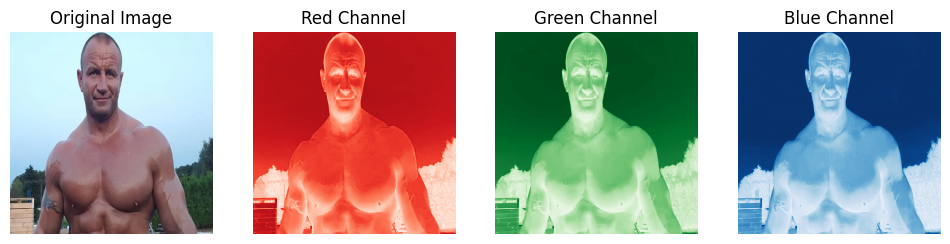

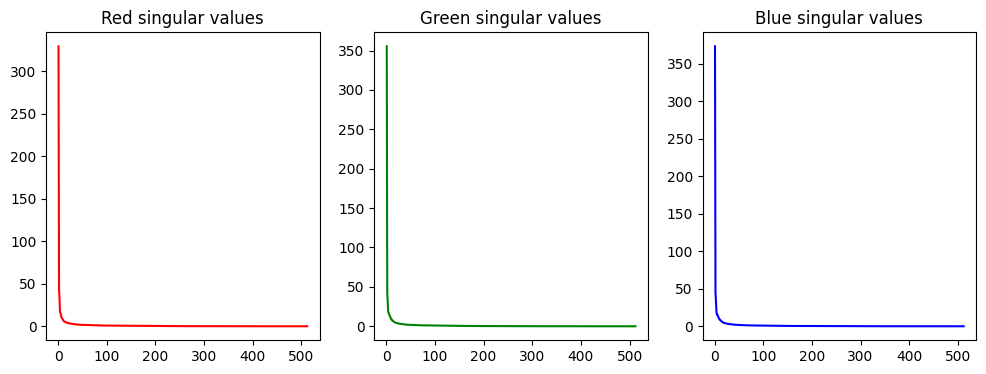

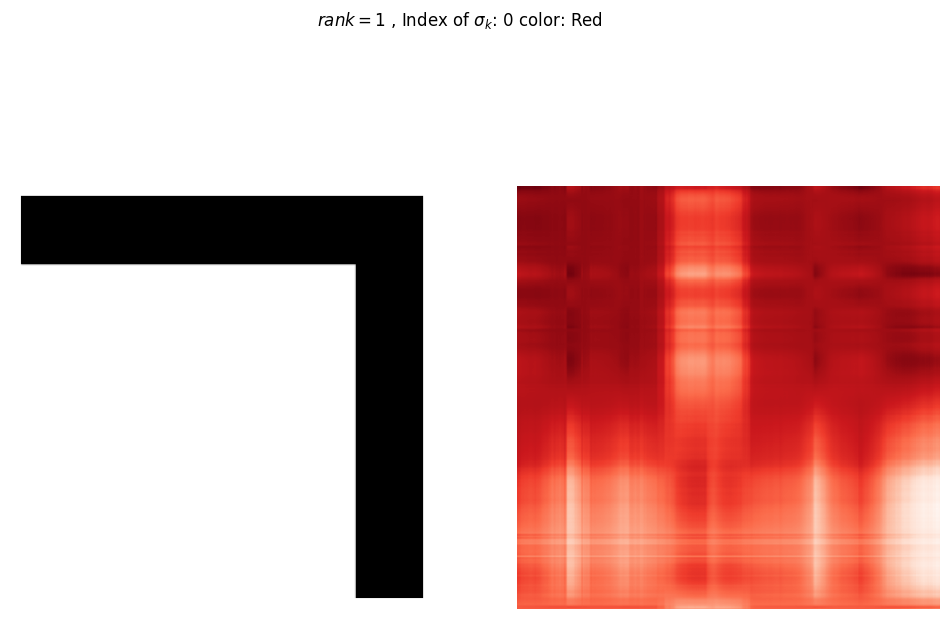

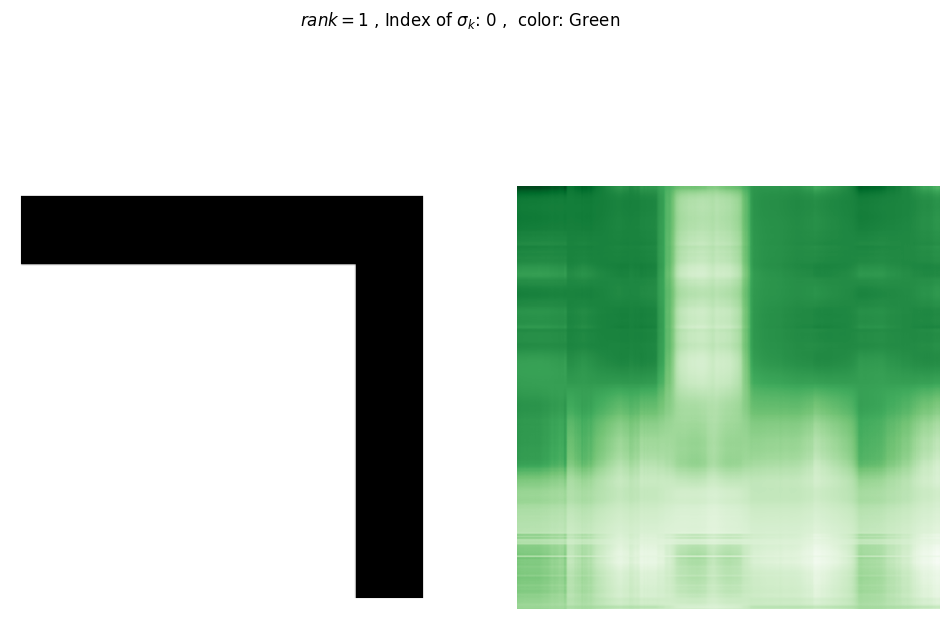

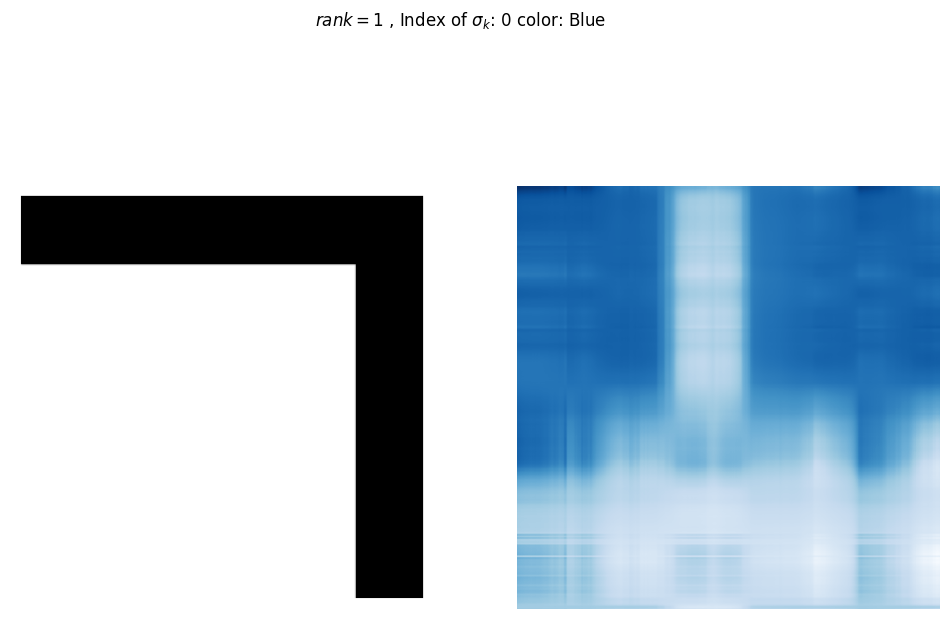

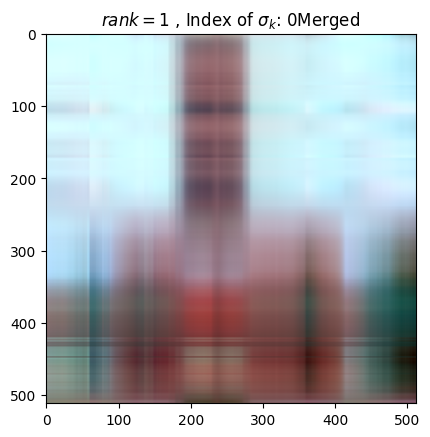

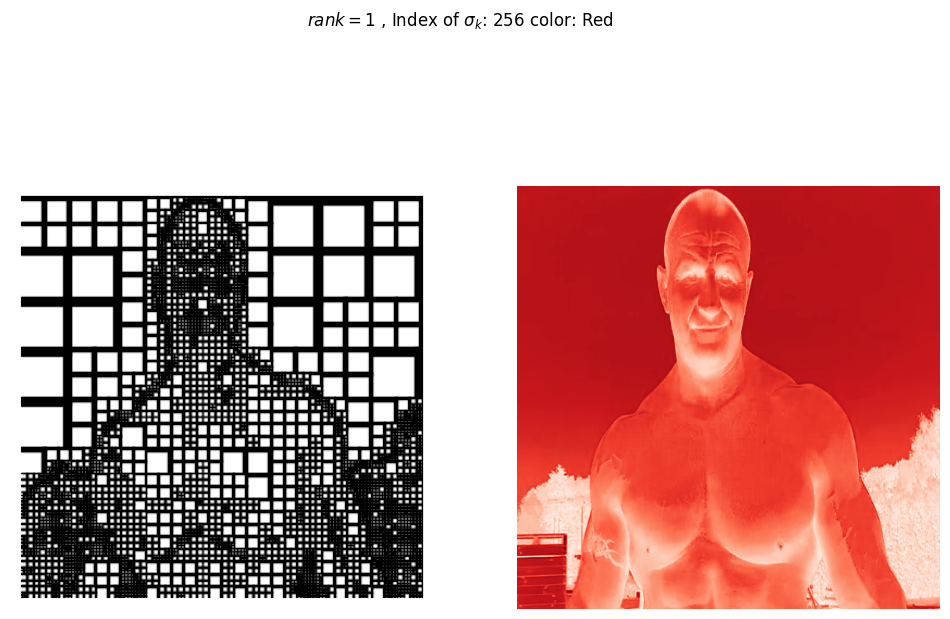

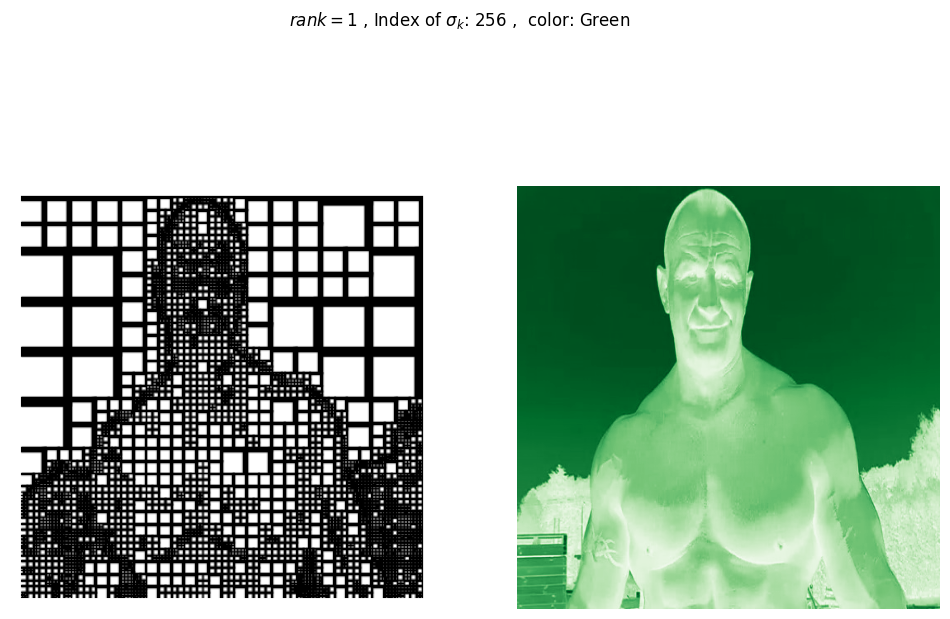

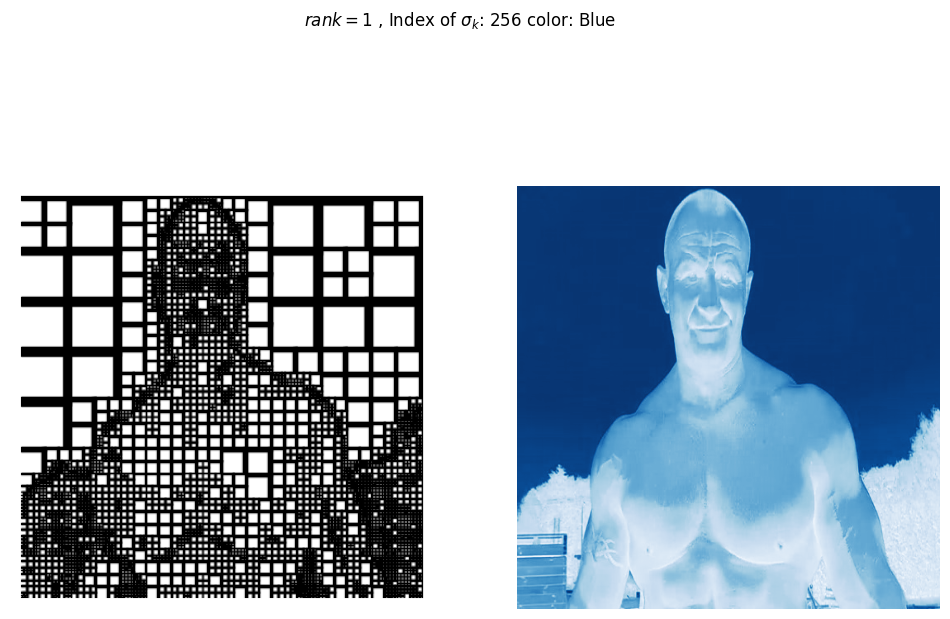

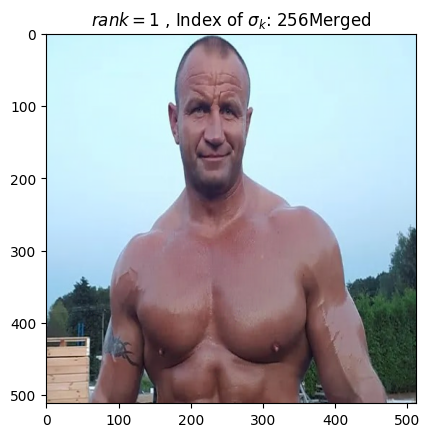

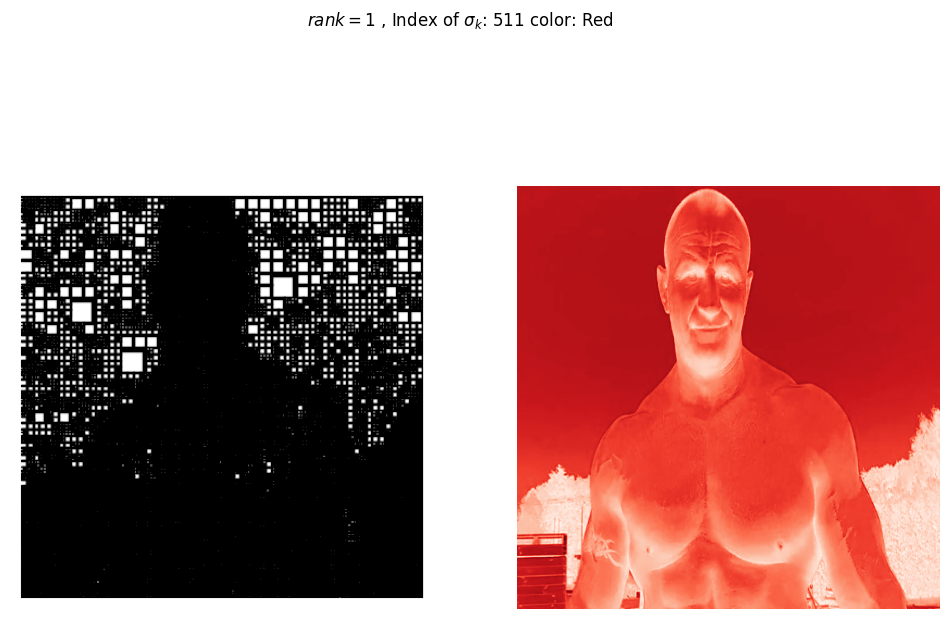

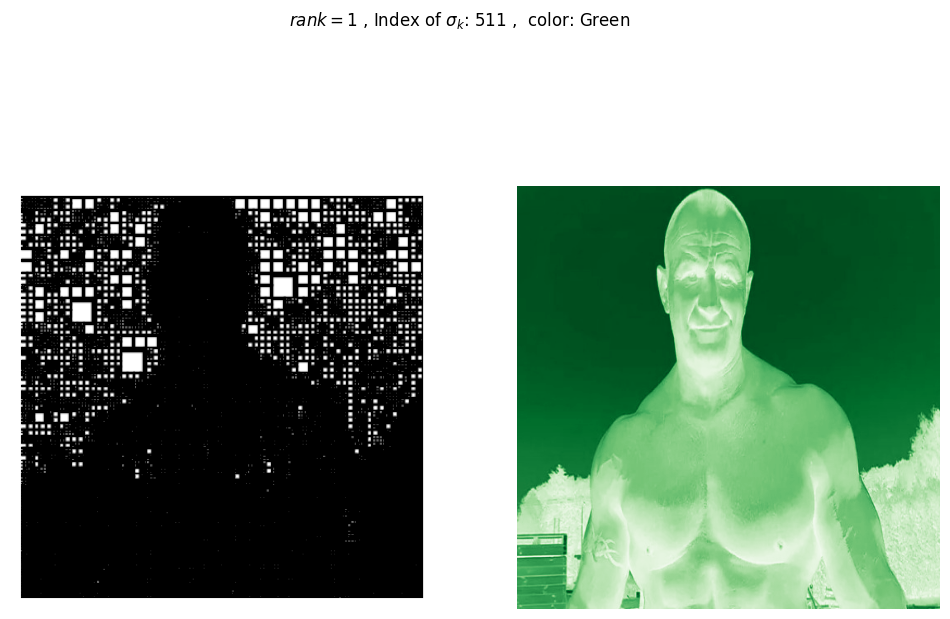

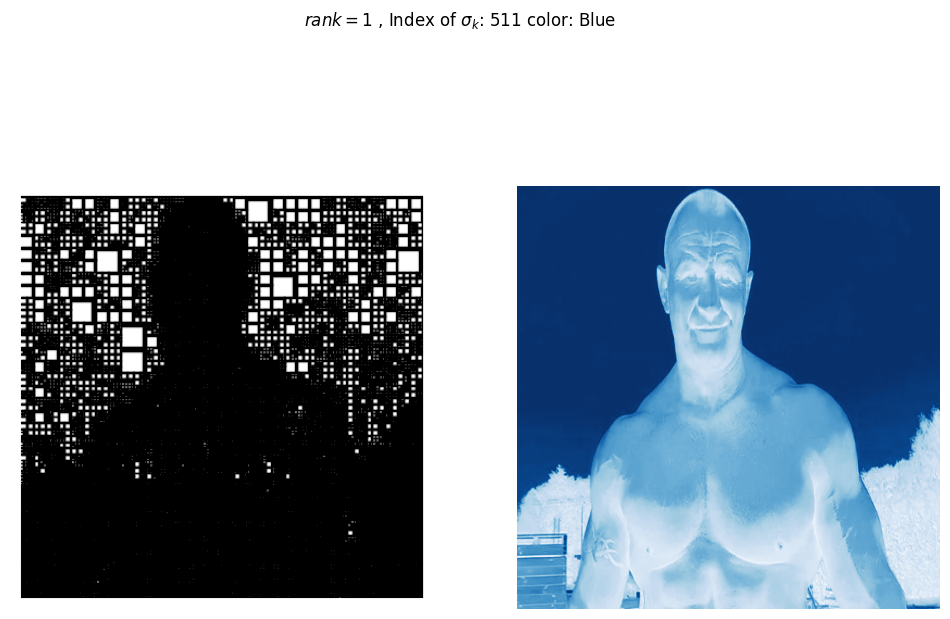

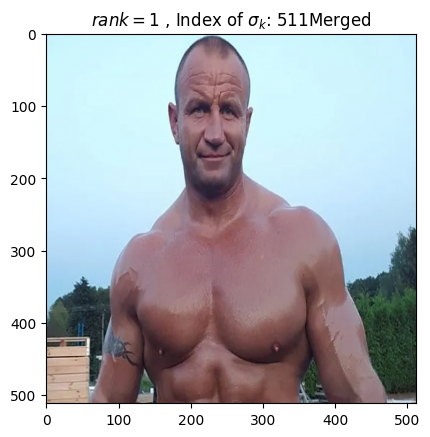

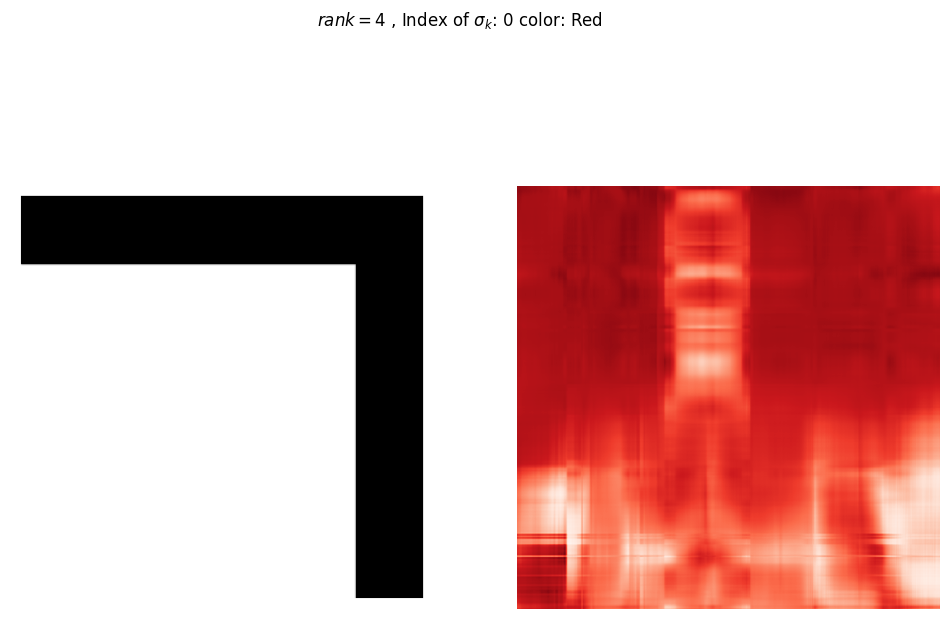

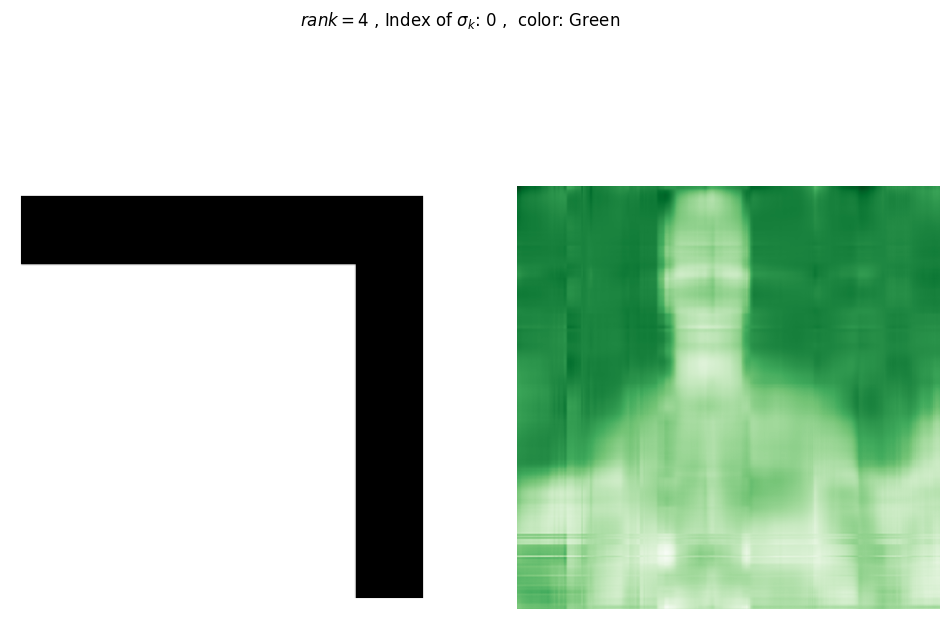

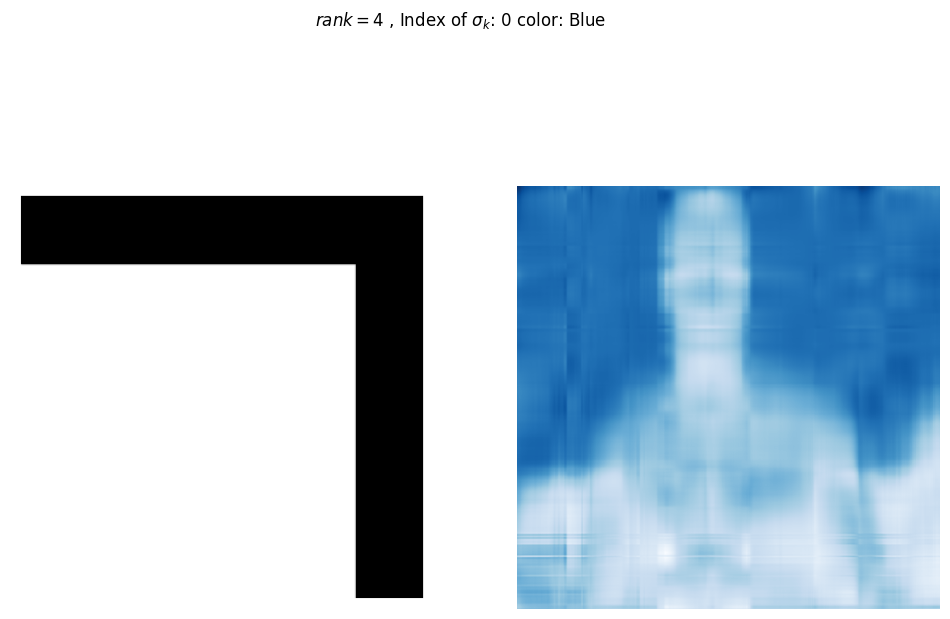

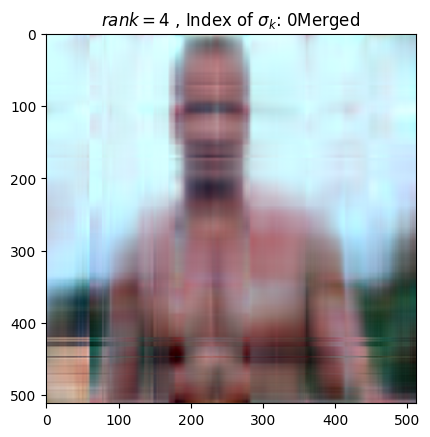

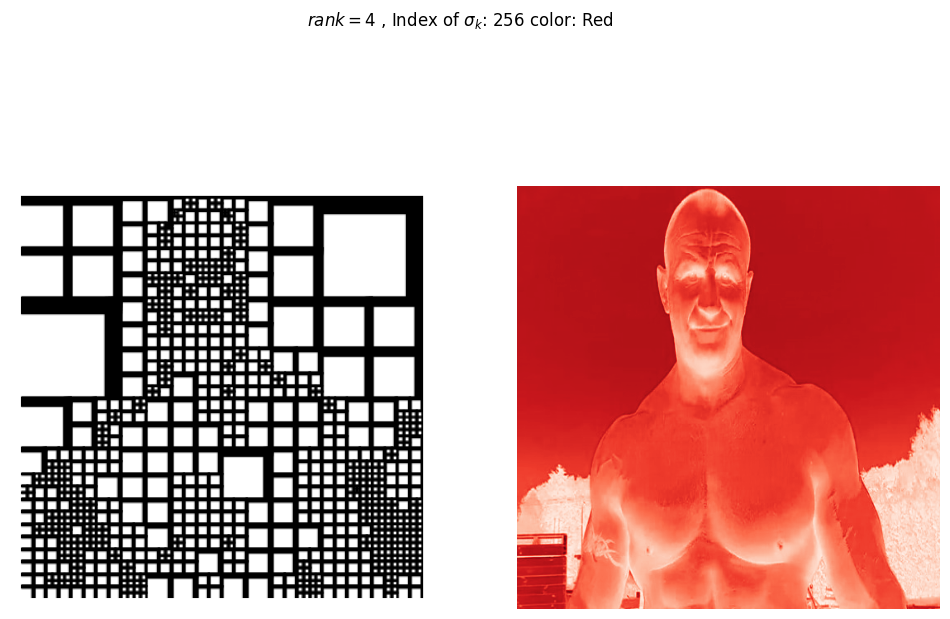

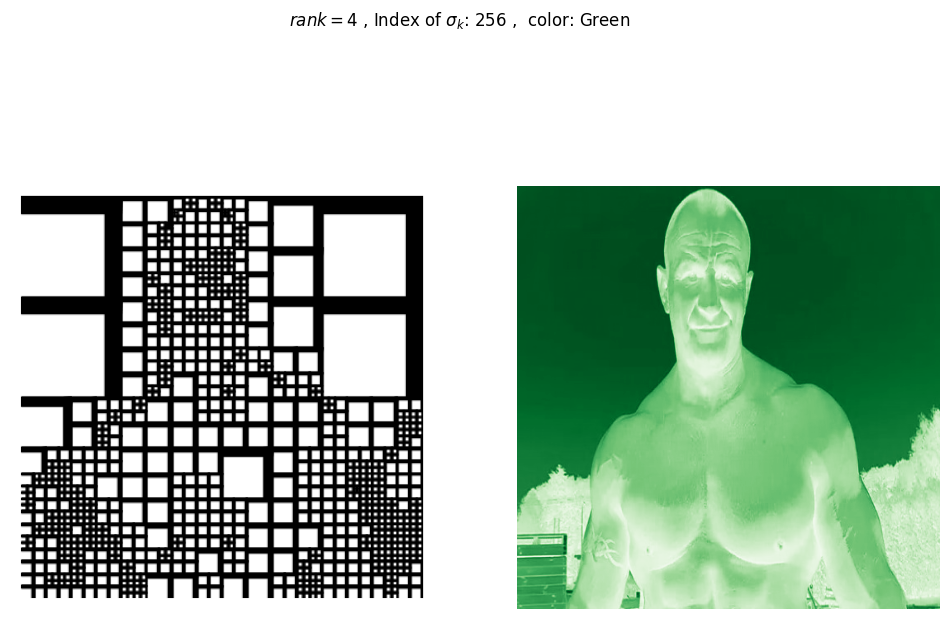

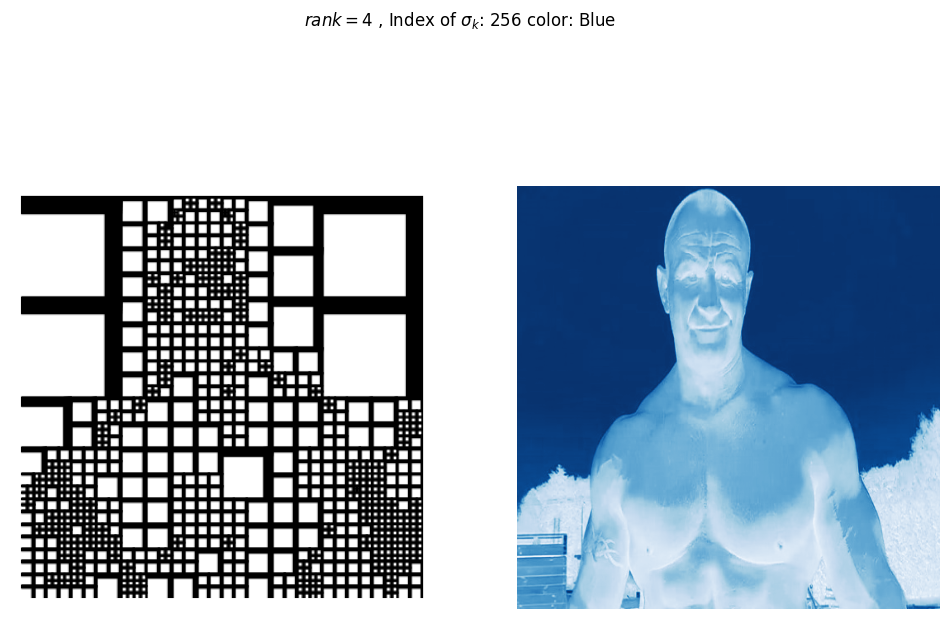

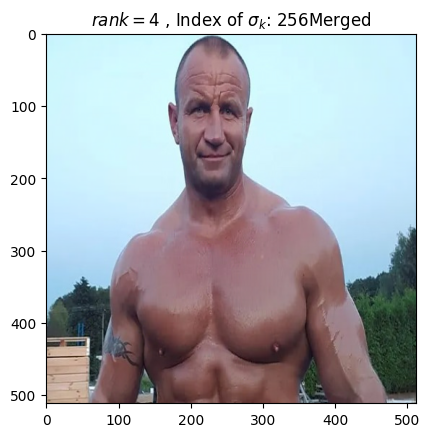

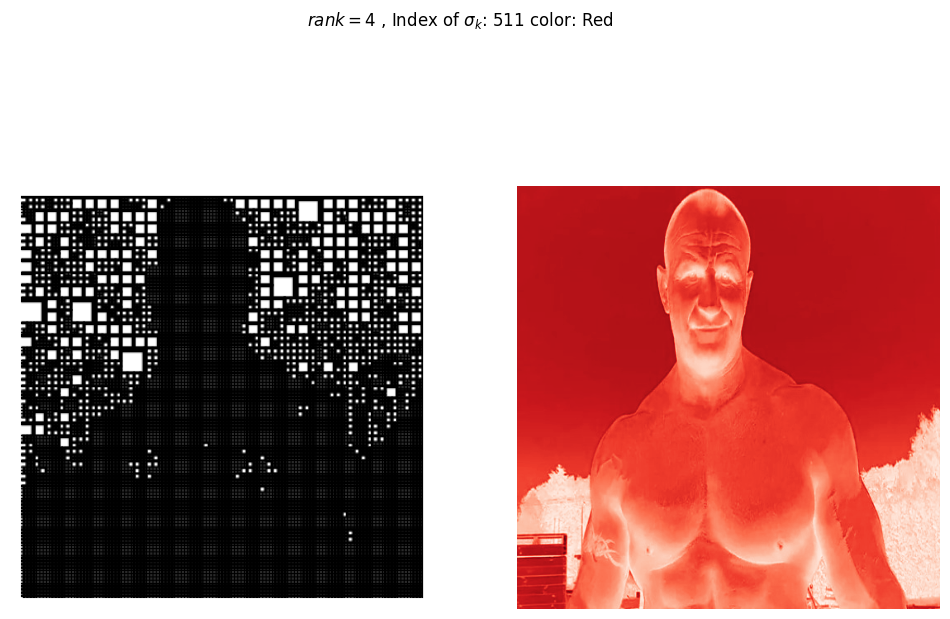

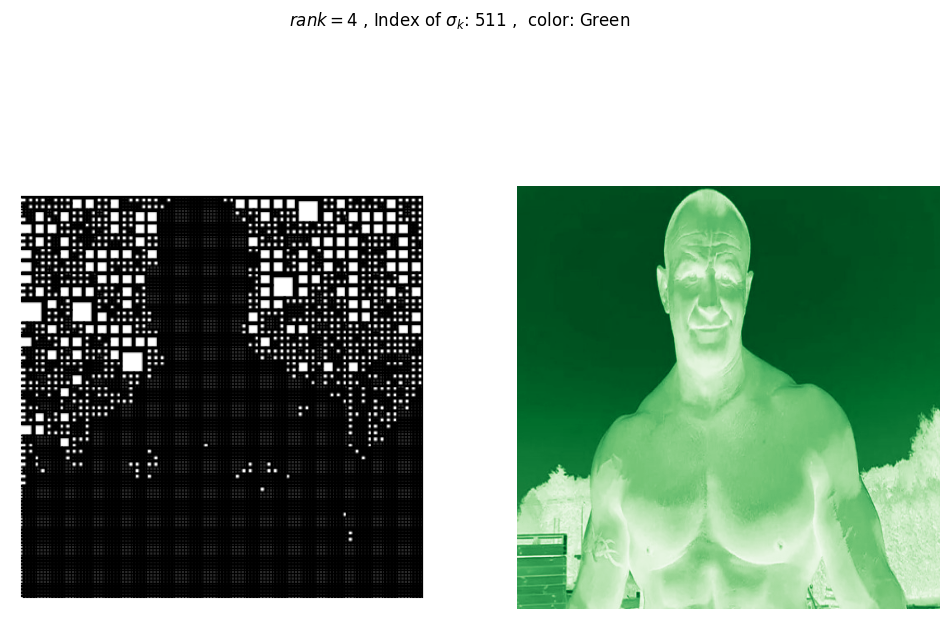

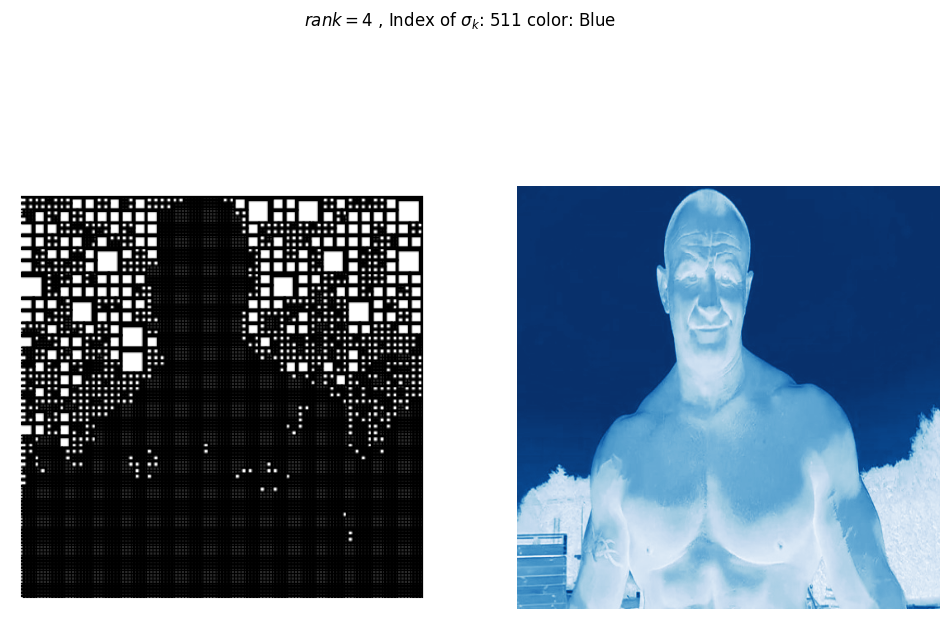

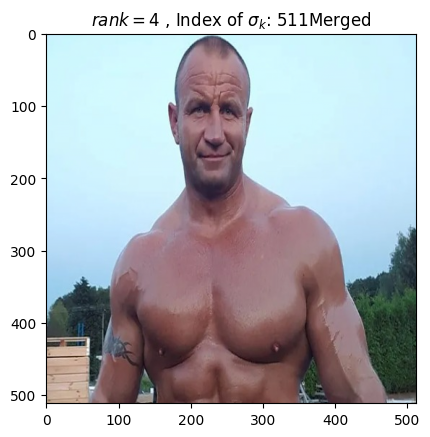

In [2]:
original_image = read_image_from_path('pudzian.jpg')

red_channel, green_channel, blue_channel = original_image[:, :, 0],original_image[:, :, 1], original_image[:, :, 2]

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(red_channel,cmap='Reds')
plt.title("Red Channel")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(green_channel,cmap = 'Greens')
plt.title("Green Channel")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap = 'Blues')
plt.title("Blue Channel")
plt.axis("off")

_, r_Sigma, _ = svd(red_channel)
_, g_Sigma, _ = svd(green_channel)
_, b_Sigma, _ = svd(blue_channel)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Red singular values")
plt.plot(range(1, len(r_Sigma) + 1), r_Sigma, color='red')
plt.subplot(1, 3, 2)
plt.title("Green singular values")
plt.plot(range(1, len(g_Sigma) + 1), g_Sigma, color='green')
plt.subplot(1, 3, 3)
plt.title("Blue singular values")
plt.plot(range(1, len(b_Sigma) + 1), b_Sigma, color='blue')
plt.show()


for r in (1, 4):
    for sig_id in (0, len(r_Sigma) // 2, len(r_Sigma) - 1):
        # Przetwarzanie kanału czerwonego
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))
        fig.suptitle(
            r"$rank=$"
          + f"{r}"
          + " , "
          + r"Index of $\sigma_k$:"
          + f" {sig_id}"
          + r" color: Red"

        )
        root = CreateTree(red_channel, r, r_Sigma[sig_id])
        orgr = Decompress(root)
        tree = DrawTree(root)

        axes[0].imshow(tree)
        axes[0].axis("off")

        axes[1].imshow(orgr, cmap='Reds')
        axes[1].axis("off")

        plt.show()
        del root, tree, fig, axes
        gc.collect()  # Wymuszenie zwolnienia pamięci

        # Przetwarzanie kanału zielonego
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))
        fig.suptitle(
            r"$rank=$"
          + f"{r}"
          + " , "
          + r"Index of $\sigma_k$:"
          + f" {sig_id}"
          + " , "
          + " color: Green"

        )




        root = CreateTree(green_channel, r, g_Sigma[sig_id])
        orgg = Decompress(root)
        tree = DrawTree(root)

        axes[0].imshow(tree)
        axes[0].axis("off")

        axes[1].imshow(orgg, cmap='Greens')
        axes[1].axis("off")

        plt.show()
        del root, tree, fig, axes
        gc.collect()  # Wymuszenie zwolnienia pamięci

        # Przetwarzanie kanału niebieskiego
        fig, axes = plt.subplots(1, 2, figsize=(12, 8))
        fig.suptitle(
            r"$rank=$"
          + f"{r}"
          + " , "
          + r"Index of $\sigma_k$:"
          + f" {sig_id}"
          + r" color: Blue"

        )




        root = CreateTree(blue_channel, r, b_Sigma[sig_id])
        orgb = Decompress(root)
        tree = DrawTree(root)

        axes[0].imshow(tree)
        axes[0].axis("off")

        axes[1].imshow(orgb, cmap='Blues')
        axes[1].axis("off")

        plt.show()
        del root, tree, fig, axes
        gc.collect()  # Wymuszenie zwolnienia pamięci

        #zmergowanie zdekompresowanych kanałów

        orgimg = merge_RGB(orgr, orgg, orgb)
        plt.imshow(orgimg)
        plt.title(
            r"$rank=$"
          + f"{r}"
          + " , "
          + r"Index of $\sigma_k$:"
          + f" {sig_id}"
          + r"Merged"

        )
        plt.show()
        del orgimg, orgr, orgg, orgb

        gc.collect()








